In [439]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform

In [440]:
class MWPDataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.mwp_frame = pd.read_csv(csv_file)[:10000]
        self.transform = transform
        
    def __len__(self):
        return len(self.mwp_frame)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.mwp_frame.iloc[idx,0]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image,(32,32))
        image = np.moveaxis(image,-1,0)
        img_label = self.mwp_frame.iloc[idx,1]
        sample = {"image":image,"label":img_label}
        
        return sample

In [441]:
mwp_dataset = MWPDataset("./csv/train.csv", transform = transform.resize)
mwp_testset = MWPDataset("./csv/test.csv",transform = transform.resize)

In [442]:
mwp_dataset.mwp_frame

,image,label
0,./data/Train/NotPerson/castor_canadensis_s_000...,2
1,./data/Train/NotPerson/wing_chair_s_000451.png,2
2,./data/Train/NotPerson/clavier_s_000105.png,2
3,./data/Train/NotPerson/mako_shark_s_000012.png,2
4,./data/Train/WithMask/841.png,1
...,...,...
9995,./data/Train/NotPerson/lapin_s_002766.png,2
9996,./data/Train/NotPerson/world_trade_center_s_00...,2
9997,./data/Train/NotPerson/bed_s_001138.png,2
9998,./data/Train/NotPerson/cankerworm_s_000526.png,2


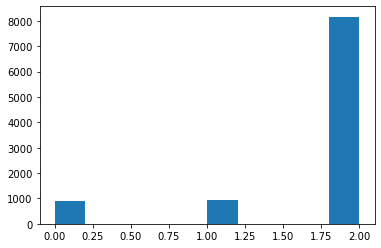

In [443]:
plt.hist(mwp_dataset.mwp_frame['label']);

In [444]:
mwp_dataset[10]['image'].shape

(3, 32, 32)

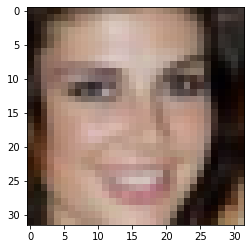

In [445]:
plt.imshow(np.transpose(mwp_dataset[5]['image'],(1,2,0)))

<h2> Training </h2>

In [446]:
import torch.nn as nn
import torch.nn.functional as F

In [447]:
class Network(nn.Module):
    def __init__(self, num_channels=32, num_labels=3):
#         super(Network, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=num_channels,out_channels=8, kernel_size=(3,3),stride =(1,1), padding=(1,1))
#         self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
#         self.conv2 = nn.Conv2d(in_channels=8,out_channels=16, kernel_size=(3,3),stride =(1,1), padding=(1,1))
#         self.fc1 = nn.Linear(16 * 8 * 8 , num_labels)
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        
    def forward(self,x):
#         x = nn.functional.relu(self.conv1(x))
#         x = self.pool(x)
#         x = nn.functional.relu(self.conv2(x))
#         x = self.pool(x)
#         x = nn.functional.reshape(x.shape[0], -1)
#         x = self.fc1(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    

In [448]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channel = 32
num_labels = 3
lr = 0.001
num_epoch = 5

In [449]:
device

device(type='cuda')

In [450]:
train_loader = DataLoader(dataset = mwp_dataset ,shuffle= True)
test_loader = DataLoader(dataset = mwp_testset ,shuffle= True)

In [451]:
model = Network().to(device)

In [452]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [453]:
len(test_loader)

992

In [454]:
losses = []
for epoch in range(num_epoch):
    total_loss = 0.0
    for idx, batch in enumerate(train_loader):
        data, targets = batch['image'],batch['label']
        data = data.to(device=device).to(torch.float)
        targets = targets.to(device=device)
        scores = model(data)
        loss = loss_function(scores,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
torch.save(model.state_dict(),"./models/model.pt")

In [455]:
losses = np.array(losses)/100.0
steps = np.arange(0,num_epoch)

[0 1 2 3 4]


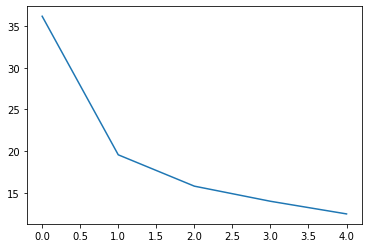

In [456]:
print(steps)
plt.plot(steps,losses);

In [457]:
def acc(testloader,net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader):
            image, labels = data['image'].to(device=device).to(torch.float),data['label'].to(device=device)

            outputs = net(image)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 992 test images: %d %%' % (
        100 * correct / total))

In [458]:
acc(test_loader,model)

Accuracy of the network on the 992 test images: 72 %
